# Detecting Branches in Clusters

HDBSCAN\* is often used to find subpopulations in exploratory data analysis
workflows. Not only clusters themselves, but also their shape can represent
meaningful subpopulations. For example, a Y-shaped cluster may represent an
evolving process with two distinct end-states. Detecting these branches can
reveal interesting patterns that are not captured by density-based clustering.

In [1]:
import numpy as np
import fast_hdbscan

import requests
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize":(8,8)})
data_request = requests.get(
    "https://github.com/scikit-learn-contrib/hdbscan/blob/master/notebooks/clusterable_data.npy?raw=true"
)
orig_data = np.load(BytesIO(data_request.content))

For example, HDBSCAN\* finds 4 clusters in the datasets below, which does not
inform us of the branching structure:

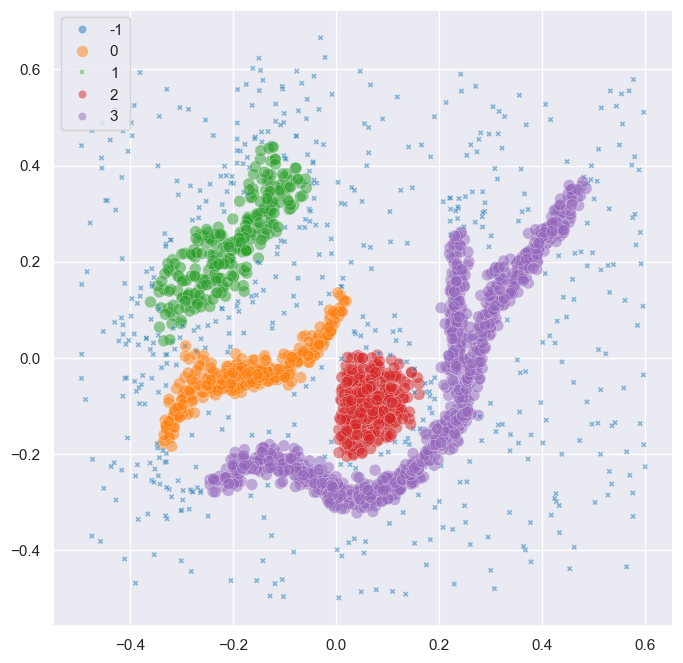

In [2]:
# merge three clusters into Y-shape
p0 = (0.13, -0.26)
p1 = (0.24, -0.12)
p2 = (0.32, 0.2)
segments = [
    np.column_stack(
        (np.linspace(p_start[0], p_end[0], 100), 
         np.linspace(p_start[1], p_end[1], 100))
    )
    + np.random.normal(size=(100, 2), scale=0.01)
    for p_start, p_end in [(p0, p1), (p1, p2)]
]

data = np.concatenate((orig_data, *segments))
clusterer = fast_hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
sns.scatterplot(
    x=data.T[0],
    y=data.T[1],
    hue=clusterer.labels_,
    style=clusterer.labels_ < 0,
    size=clusterer.labels_ < 0,
    palette="tab10",
    alpha=0.5,
)
plt.show()

Alternatively, HDBSCAN\*'s leaf clusters provide more detail. They segment the
points of different branches into distinct clusters. However, the partitioning
and cluster hierarchy does not (necessarily) tell us how those clusters combine
into a larger shape.

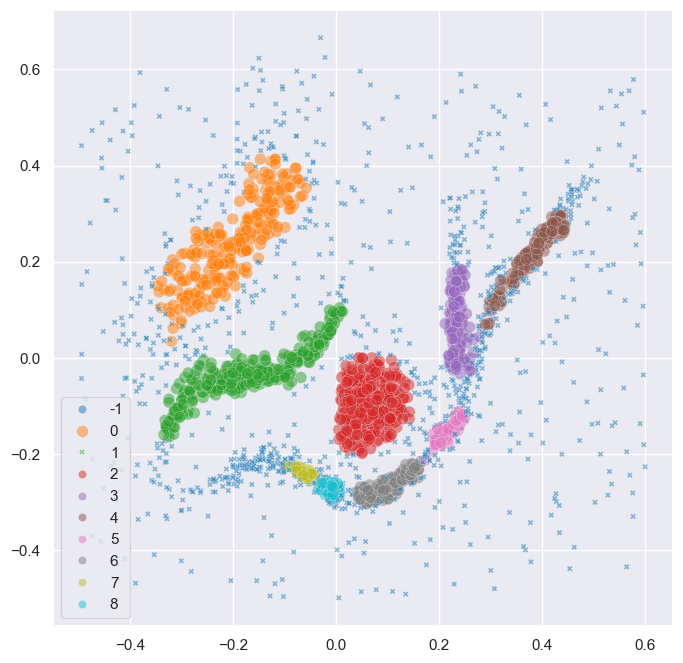

In [3]:
leaf_clusterer = fast_hdbscan.HDBSCAN(
    min_cluster_size=25, cluster_selection_method="leaf"
).fit(data)
sns.scatterplot(
    x=data.T[0],
    y=data.T[1],
    hue=leaf_clusterer.labels_,
    style=leaf_clusterer.labels_ < 0,
    size=leaf_clusterer.labels_ < 0,
    palette="tab10",
    alpha=0.5,
)
plt.show()

This is where the branch detection post-processing step comes into play. The
functionality is described in detail by [Bot et
al.](https://peerj.com/articles/cs-2792/) (please cite this paper when using
this functionality). It operates on the detected clusters and extracts a
branch-hierarchy analogous to HDBSCAN\*'s condensed cluster hierarchy. The
process is very similar to HDBSCAN\* clustering, except that it operates on an
in-cluster eccentricity rather than a density measure. Where peaks in a density
profile correspond to clusters, the peaks in an eccentricity profile correspond
to branches:

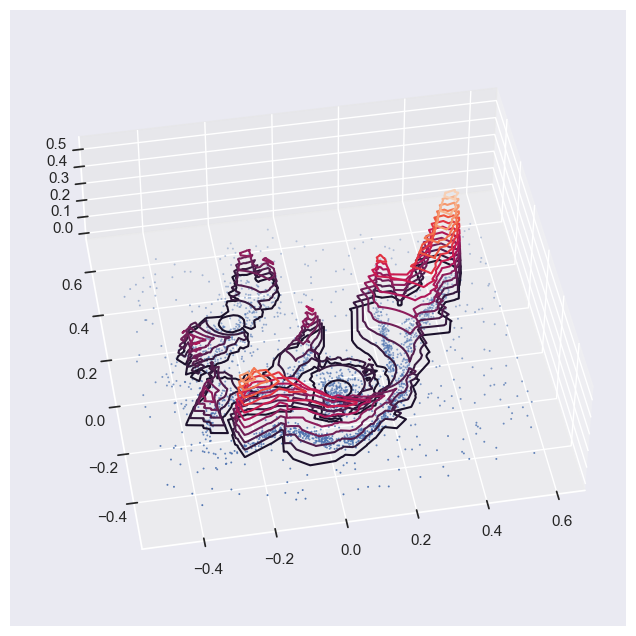

In [4]:
import matplotlib.tri as mtri

eccentricities = np.zeros(data.shape[0])
num_clusters = clusterer.labels_.max() + 1
for label in range(num_clusters):
    mask = clusterer.labels_ == label
    centroid = np.average(
        data[mask],
        weights=clusterer.probabilities_[mask],
        axis=0,
    )
    eccentricities[mask] = np.linalg.norm(data[mask] - centroid, axis=1)

fig = plt.figure()
tri = mtri.Triangulation(data[:, 0], data[:, 1])
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=45, azim=-100)
ax.scatter(
    data.T[0],
    data.T[1],
    np.repeat(eccentricities.min(), data.shape[0]),
    s=2,
    edgecolor="none",
    linewidth=0,
)
ax.tricontour(tri, eccentricities, levels=np.linspace(0, eccentricities.max(), 15))
zlim = ax.get_zlim()
ax.set_box_aspect(aspect=(3, 3, 1))

Using the branch detection functionality is fairly straightforward. Using
`fast_hdbscan` one can simply configure the ``BranchDetector`` class and fit it
with the `fast_hdbscan.HDBSCAN` object. By default `BranchDetector` uses the
values of the given `HDBSCAN` object for the parameters they share.

The resulting partitioning reflects subgroups for clusters and their branches:

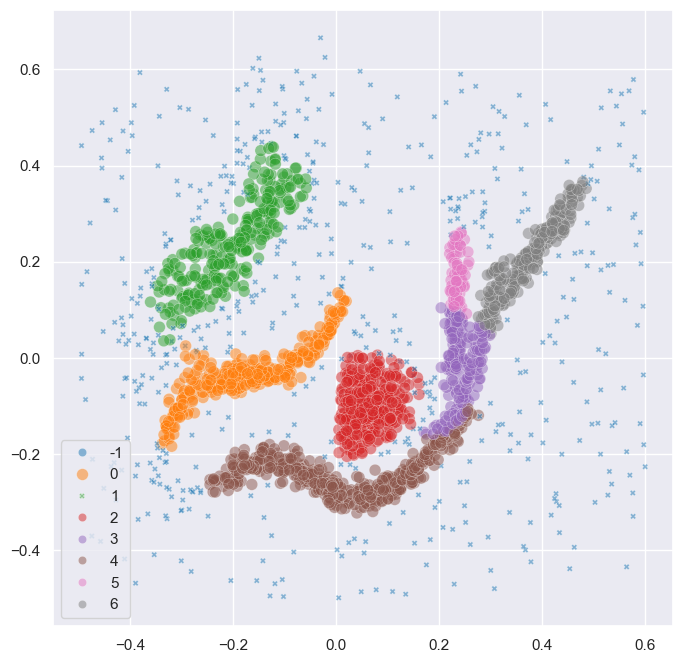

In [5]:
branch_detector = fast_hdbscan.BranchDetector().fit(clusterer)
sns.scatterplot(
    x=data.T[0],
    y=data.T[1],
    hue=branch_detector.labels_,
    style=branch_detector.labels_ < 0,
    size=branch_detector.labels_ < 0,
    palette="tab10",
    alpha=0.5,
)
plt.show()

The centers of clusters get a non-noise label different from the branches in the
cluster. This behavior can be changed by setting the `propagate_labels=True`
parameter or by  calling `propagated_labels()` after fitting.

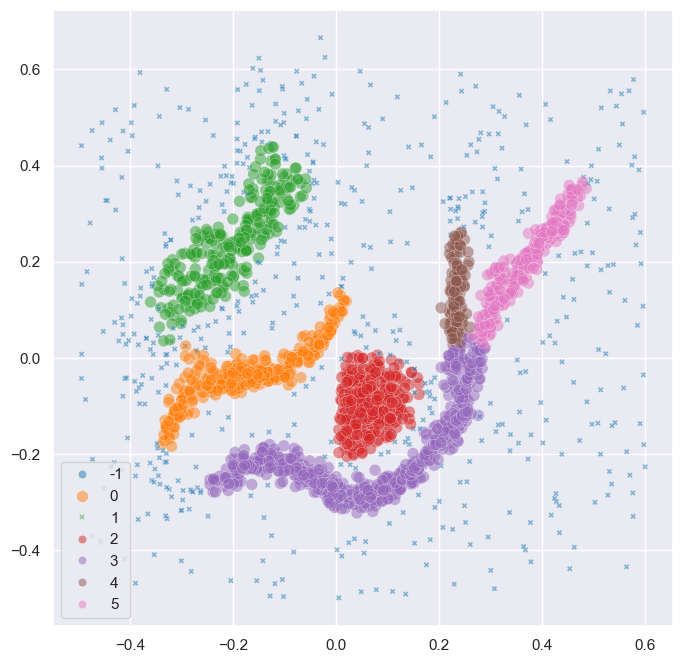

In [6]:
labels, _ = branch_detector.propagated_labels()
sns.scatterplot(
    x=data.T[0],
    y=data.T[1],
    hue=labels,
    style=labels < 0,
    size=labels < 0,
    palette="tab10",
    alpha=0.5,
)
plt.show()

## Parameter selection

The `BranchDetector`'s main parameters are very similar to HDBSCAN\*. Most
guidelines for tuning HDBSCAN\* also apply to the branch detector:

- `min_cluster_size` configures how many points branches need to contain. Values
  around 10 to 25 points tend to work well. Lower values are useful when looking
  for smaller structures. Higher values can be used to suppress noise if
  present.
- `max_cluster_size`. Branches with more than the specified number of points are
  skipped, selecting their descendants in the hierarchy instead.
- `cluster_selection_method`. The leaf and Excess of Mass (EOM) strategies are
  used to select branches from the condensed hierarchies. By default, branches
  are only reflected in the final labelling for clusters that have 3 or more
  branches (at least one bifurcation).
- `cluster_selection_epsilon` can be used to suppress branches that merge at low
  eccentricity values (y-value in the condensed hierarchy plot).
- `cluster_selection_persistence` can be used to suppress branches with a short
  eccentricity range (y-range in the condensed hierarchy plot).
- `allow_single_cluster`. When enabled, clusters with bifurcations will be given
  a single label if the root segment contains most eccentricity mass (i.e.,
  branches already merge far from the center and most points are central).

One parameter is unique to the `BranchDetector` class:

- `label_sides_as_branches` determines whether the sides of an elongated cluster
  without bifurcations (l-shape) are represented as distinct subgroups. By
  default a cluster needs to have one bifurcation (Y-shape) before the detected
  branches are represented in the final labelling.

Unlike the `hdbscan` version, `fast_hdbscan`'s `BranchDetector` does not support
the `branch_detection_method` parameter. This implementation will always use a
`"core"` graph to determine which points are connected within a cluster. A
`"core"` graph combines nearest neighbors and the minimum spanning tree of a
cluster. It contains all connectivity within the points' core distances and
forms a single connected component per cluster.

## Useful attributes

The `BranchDetector` class contains several useful attributes for exploring
datasets.

### Branch hierarchy

Branch hierarchies reflect the tree-shape of clusters. Like the cluster
hierarchy, branch hierarchies can be used to interpret which branches exist. In
addition, they reflect how far apart branches merge into the cluster. 

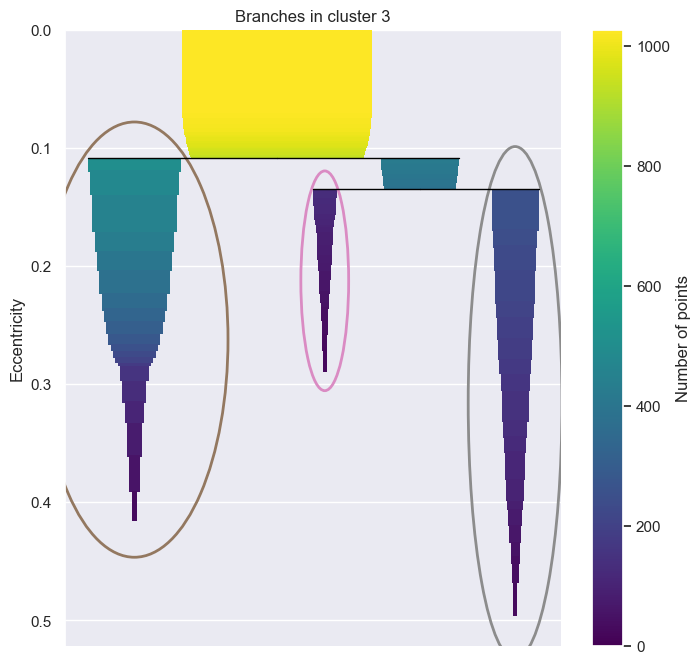

In [7]:
branch_detector.condensed_trees_[3].plot(select_clusters=True, selection_palette=['C5', 'C6', 'C7'])
plt.ylabel("Eccentricity")
plt.title(f"Branches in cluster {3}")
plt.show()

The length of the branches also says something about the compactness /
elongatedness of clusters. For example, the branch hierarchy for the orange
~-shaped cluster is quite different from the same hierarchy for the central
o-shaped cluster.

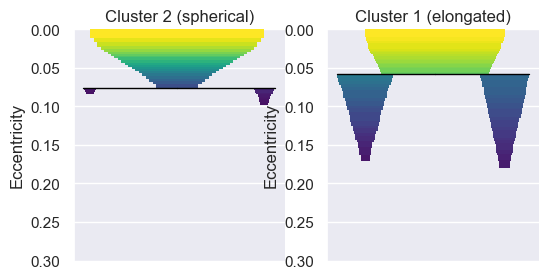

In [8]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
branch_detector.condensed_trees_[2].plot(colorbar=False)
plt.ylim([0.3, 0])
plt.ylabel("Eccentricity")
plt.title(f"Cluster {2} (spherical)")

plt.subplot(1, 2, 2)
branch_detector.condensed_trees_[1].plot(colorbar=False)
plt.ylim([0.3, 0])
plt.ylabel("Eccentricity")
plt.title(f"Cluster {1} (elongated)")
plt.show()

### Cluster approximation graphs

Branches are detected using a graph that approximates the connectivity within a
cluster. These graphs are available in the `cluster_approximation_graph_`
property and can be used to visualize data and the branch-detection process. The
plotting function is based on the networkx API and uses networkx functionality
to compute a layout if positions are not provided. Using UMAP to compute
positions can be faster and more expressive. Several helper functions for
exporting to numpy, pandas, and networkx are available.

For example, a figure with points coloured by the final labelling:

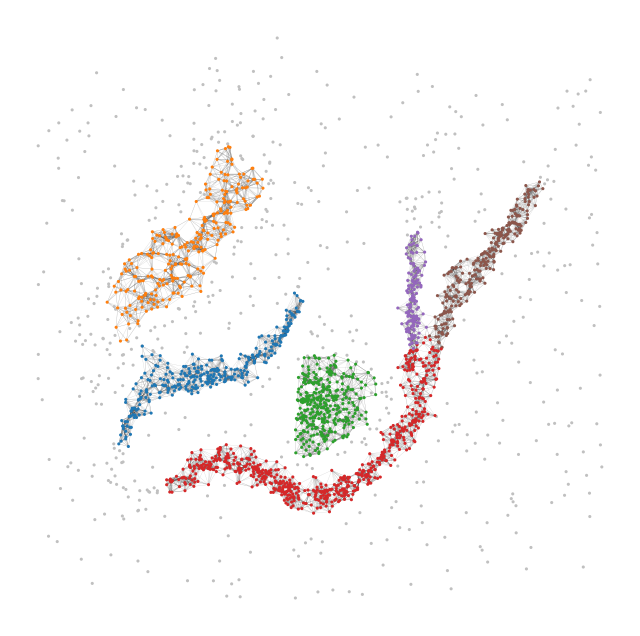

In [9]:
g = branch_detector.approximation_graph_
g.plot(positions=data, node_size=5, edge_width=0.2, edge_alpha=0.2)
plt.show()

Or, a figure with the edges coloured by centrality:

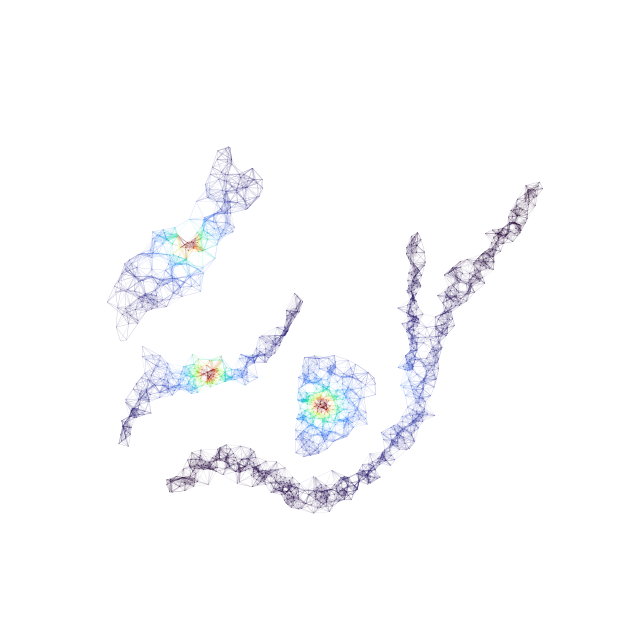

In [10]:
g.plot(
    positions=data,
    node_alpha=0,
    edge_color="centrality",
    edge_cmap="turbo",
    edge_width=0.2,
    edge_alpha=0.2,
    edge_vmax=100,
)
plt.show()

## Detect branches in other clusters

It is possible to evaluate the `BranchDetector` class with non-HDBSCAN clusters
through the optional arguments of its `.fit()` method. In the example below, two
clusters are merged manually, resulting in a different branching structure. This
functionality can be used to look for branches in, f.i., DBSCAN labels.

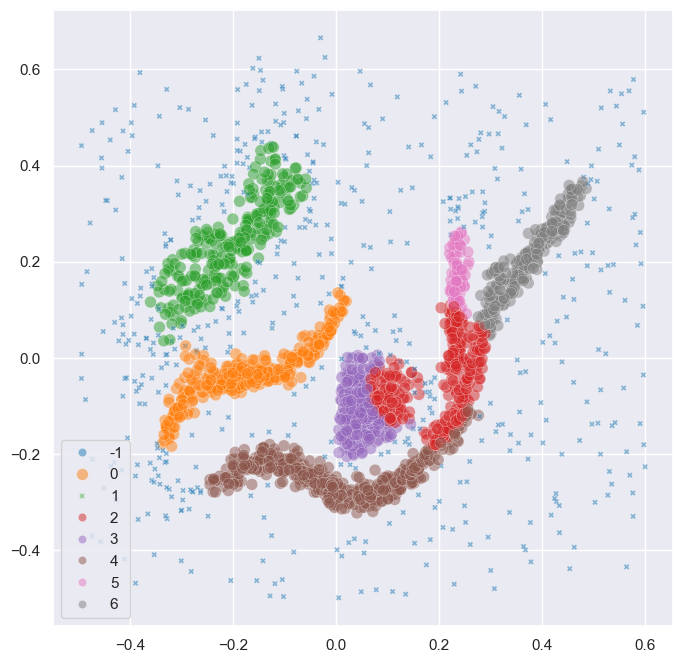

In [11]:
# Valid option
custom_labels = clusterer.labels_.copy()
custom_labels[clusterer.labels_ == 3] = 2
branch_detector.fit(clusterer, custom_labels)

sns.scatterplot(
    x=data.T[0],
    y=data.T[1],
    hue=branch_detector.labels_,
    style=branch_detector.labels_ < 0,
    size=branch_detector.labels_ < 0,
    palette="tab10",
    alpha=0.5,
)
plt.show()

Custom clusters only work if they are within-cluster-path-connected in HDBSCAN's
minimum spanning tree (MST). In other words, the MST edges between all points in
the cluster must form a single connected component. Custom clusters that break
this condition return the MST connected component labels instead of branches,
without looking for branches!!

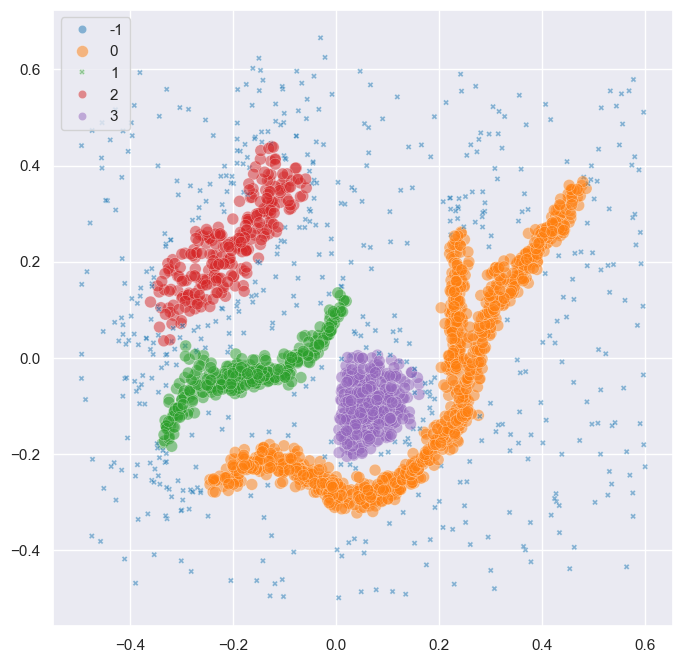

In [12]:
# Invalid labels cannot find branches!
custom_labels = clusterer.labels_.copy()
custom_labels[clusterer.labels_ == 3] = 0
branch_detector.fit(clusterer, custom_labels)

sns.scatterplot(
    x=data.T[0],
    y=data.T[1],
    hue=branch_detector.labels_,
    style=branch_detector.labels_ < 0,
    size=branch_detector.labels_ < 0,
    palette="tab10",
    alpha=0.5,
)
plt.show()

## Citing

If you used the branch-detection functionality in this library please cite our [PeerJ paper](https://peerj.com/articles/cs-2792/): 

D.M. Bot, J. Peeters, J. Liesenborgs, J. Aerts. 
*FLASC: a flare-sensitive clustering algorithm.*
PeerJ Computer Science, Volume 11, e2792, 2025.
https://doi.org/10.7717/peerj-cs.2792.

```bibtex
@article{bot2025flasc,
    title   = {{FLASC: a flare-sensitive clustering algorithm}},
    author  = {Bot, Dani{\"{e}}l M. and Peeters, Jannes and Liesenborgs, Jori and Aerts, Jan},
    year    = {2025},
    month   = {apr},
    journal = {PeerJ Comput. Sci.},
    volume  = {11},
    pages   = {e2792},
    issn    = {2376-5992},
    doi     = {10.7717/peerj-cs.2792},
    url     = {https://peerj.com/articles/cs-2792},
}
```